In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ca0fd2a3-bb83-7973-5e49-fa7d4c166ea1)


In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 5.8 MB 8.9 MB/s 
     |████████████████████████████████| 1.4 MB 61.8 MB/s 
     |████████████████████████████████| 462 kB 74.4 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvid

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [ ]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
get_lines(data_dir+'/train.txt')

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples


In [ ]:
train_samples=preprocess_text_with_line_numbers(data_dir+'/train.txt')
val_samples=preprocess_text_with_line_numbers(data_dir+'/dev.txt')
test_samples=preprocess_text_with_line_numbers(data_dir+'/test.txt')

In [ ]:
import pandas as pd

train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_sentences=train_df['text'].to_list()
val_sentences=val_df['text'].to_list()
test_sentences=test_df['text'].to_list()


In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

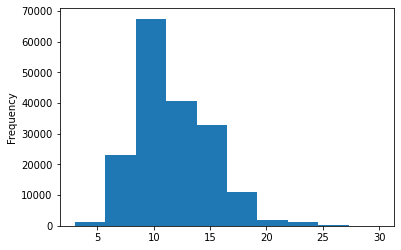

In [ ]:
train_df.total_lines.plot.hist();


In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
class_names=label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

### Model **0**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('lr',LogisticRegression(max_iter=1000))
])
model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr', LogisticRegression(max_iter=1000))])

In [ ]:
score=model_0.score(train_sentences,train_labels_encoded)
score1=model_0.score(test_sentences,test_labels_encoded)
score


0.8470228838035992

In [ ]:
score1

0.7967147834743653

In [ ]:
pred_0=model_0.predict(test_sentences)
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_labels_encoded,pred_0))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      3621
           1       0.73      0.70      0.71      4571
           2       0.85      0.90      0.87      9897
           3       0.67      0.52      0.59      2333
           4       0.85      0.86      0.86      9713

    accuracy                           0.80     30135
   macro avg       0.75      0.73      0.73     30135
weighted avg       0.79      0.80      0.79     30135



In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
import tensorflow as tf

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

In [ ]:
import numpy as np
sen_len=[len(i.split()) for i in train_sentences]
np.mean(sen_len)

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

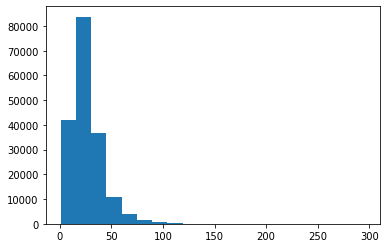

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sen_len,bins=20)

In [ ]:
out_len=int(np.percentile(sen_len,95))
out_len

55

Text Vectorizer Layer

In [ ]:
max_vocab=68000

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vec=TextVectorization(max_tokens=max_vocab,output_sequence_length=out_len)

In [ ]:
text_vec.adapt(train_sentences)

In [ ]:
words=text_vec.get_vocabulary()
new_vocab=len(words)


Embedding Layer


In [ ]:
from tensorflow.keras.layers import Embedding

embedding=Embedding(input_dim=new_vocab,output_dim=128,mask_zero=True)


Creating Datasets(to run as fast as possible)

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_encoded))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_encoded))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_encoded))

In [ ]:
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>



### Model_1


In [ ]:
input=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x=text_vec(input)
x=embedding(x)
x=tf.keras.layers.Conv1D(64,2)(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
output=tf.keras.layers.Dense(5,activation='softmax')(x)

model_1=tf.keras.Model(input,output)
model_1.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 54, 64)            16448     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1.fit(train_dataset,epochs=3,validation_data=test_dataset)

Epoch 1/3
5627/5627 [==============================] - 53s 9ms/step - loss: 0.6316 - accuracy: 0.7681 - val_loss: 0.5870 - val_accuracy: 0.7852
Epoch 2/3
5627/5627 [==============================] - 48s 8ms/step - loss: 0.4820 - accuracy: 0.8305 - val_loss: 0.5999 - val_accuracy: 0.7827
Epoch 3/3
5627/5627 [==============================] - 59s 10ms/step - loss: 0.4158 - accuracy: 0.8568 - val_loss: 0.6336 - val_accuracy: 0.7771


In [ ]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.6336 - accuracy: 0.7771


[0.6335529685020447, 0.7771362066268921]

In [ ]:
model_1_pred=model_1.predict(test_dataset)

In [ ]:
model_1_pred=model_1_pred.argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded,model_1_pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      3621
           1       0.71      0.71      0.71      4571
           2       0.89      0.81      0.84      9897
           3       0.68      0.47      0.56      2333
           4       0.78      0.91      0.84      9713

    accuracy                           0.78     30135
   macro avg       0.74      0.71      0.72     30135
weighted avg       0.78      0.78      0.77     30135



### Model_2

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
model_2=tf.keras.Sequential([
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(128,activation='relu'),
     tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(5,activation='softmax')
])
model_2.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history_2=model_2.fit(train_dataset,epochs=5,validation_data=test_dataset)

Epoch 1/5
5627/5627 [==============================] - 79s 13ms/step - loss: 0.6979 - accuracy: 0.7314 - val_loss: 0.6432 - val_accuracy: 0.7534
Epoch 2/5
 481/5627 [=>............................] - ETA: 56s - loss: 0.6418 - accuracy: 0.7544



Character-level Embeddings



In [ ]:
def split_chars(text):
 return " ".join(list(text))

In [ ]:
train_chars=[split_chars(sentence) for sentence in train_sentences]

In [ ]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

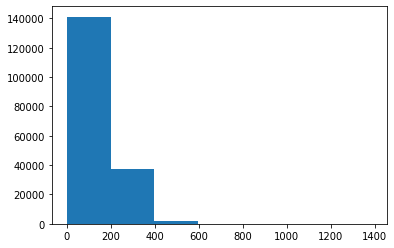

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);


In [ ]:
import numpy as np

output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
char_level_token=TextVectorization(max_tokens=len(alphabet)+2,output_sequence_length=output_seq_char_len)

In [ ]:
char_level_token.adapt(train_chars)

In [ ]:
char_vocab=char_level_token.get_vocabulary()

In [ ]:
char_level_embedding=Embedding(input_dim=len(char_vocab),output_dim=25)


### Model_3



In [ ]:
input=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x=char_level_token(input)
x=char_level_embedding(x)
x=tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
output=tf.keras.layers.Dense(5,activation='softmax')(x)

model_3=tf.keras.Model(input,output)
model_3.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           4864      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                4160

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_3=model_3.fit(train_char_dataset,epochs=3,validation_data=val_char_dataset)

Epoch 1/3
5627/5627 [==============================] - 37s 6ms/step - loss: 1.2832 - accuracy: 0.4468 - val_loss: 1.1596 - val_accuracy: 0.5191
Epoch 2/3
5627/5627 [==============================] - 31s 6ms/step - loss: 1.0994 - accuracy: 0.5394 - val_loss: 1.0356 - val_accuracy: 0.5633
Epoch 3/3
5627/5627 [==============================] - 36s 6ms/step - loss: 0.9953 - accuracy: 0.5853 - val_loss: 0.9667 - val_accuracy: 0.5961


### Model_4

In [ ]:
from tensorflow.keras import layers
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_level_token(char_inputs)
char_embeddings = char_level_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [ ]:
model_4.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

Combining datasets

In [ ]:
train_dataset_a=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_labels_b=tf.data.Dataset.from_tensor_slices(train_labels_encoded)
train_dataset_2=tf.data.Dataset.zip((train_dataset_a,train_labels_b))

train_dataset_2=train_dataset_2.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_a = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_labels_b = tf.data.Dataset.from_tensor_slices(val_labels_encoded)
val_dataset_2 = tf.data.Dataset.zip((val_dataset_a, val_labels_b))

val_dataset_2 = val_dataset_2.batch(32).prefetch(tf.data.AUTOTUNE)

Fitting Model

In [ ]:
model_4_history = model_4.fit(train_dataset_2, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_dataset_2)),
                              epochs=3,
                              validation_data=val_dataset_2,
                              validation_steps=int(0.1 * len(val_dataset_2)))

Epoch 1/3
562/562 [==============================] - 27s 37ms/step - loss: 0.9739 - accuracy: 0.6124 - val_loss: 0.7828 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7980 - accuracy: 0.6916 - val_loss: 0.7169 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 22s 40ms/step - loss: 0.7713 - accuracy: 0.7029 - val_loss: 0.6937 - val_accuracy: 0.7374


In [ ]:
model_4.evaluate(val_dataset_2)

945/945 [==============================] - 21s 22ms/step - loss: 0.6952 - accuracy: 0.7348


[0.6951634883880615, 0.734840452671051]

In [ ]:
model_4_pred=model_4.predict(val_dataset_2)

In [ ]:
model_4_pred = tf.argmax(model_4_pred, axis=1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_labels_encoded,model_4_pred))

              precision    recall  f1-score   support

           0       0.60      0.43      0.51      3449
           1       0.57      0.70      0.63      4582
           2       0.80      0.83      0.82      9964
           3       0.63      0.56      0.59      2376
           4       0.82      0.80      0.81      9841

    accuracy                           0.73     30212
   macro avg       0.68      0.67      0.67     30212
weighted avg       0.74      0.73      0.73     30212



### Model_5

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

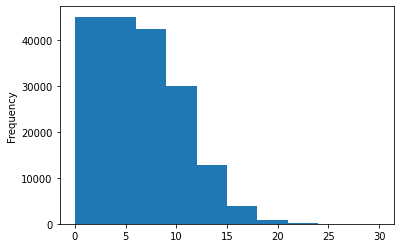

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
train_line_number_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),15)
val_line_number_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),15)
test_line_number_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),15)

train_line_number_one_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
train_total_lines_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)
train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
t_input=tf.keras.layers.Input(shape=[],dtype=tf.string)
x=tf_hub_embedding_layer(t_input)
t_output=tf.keras.layers.Dense(128,activation='relu')(x)
t_model=tf.keras.Model(t_input,t_output)

c_input=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_level_token(c_input)
char_embeddings = char_level_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=c_input,
                            outputs=char_bi_lstm)

line_numbers_input=tf.keras.layers.Input(shape=(15,),dtype=tf.float32)
x1=tf.keras.layers.Dense(64,activation='relu')(line_numbers_input)
line_numbers_model=tf.keras.Model(line_numbers_input,x1)


total_lines_input=tf.keras.layers.Input(shape=(20,),dtype=tf.float32)
x2=tf.keras.layers.Dense(64,activation='relu')(total_lines_input)
total_lines_model=tf.keras.Model(total_lines_input,x2)

combine1=tf.keras.layers.Concatenate()([t_model.output,char_model.output])

z=tf.keras.layers.Dropout(0.5)(combine1)

combine_final=tf.keras.layers.Concatenate()([line_numbers_model.output,total_lines_model.output,z])

output=tf.keras.layers.Dense(5,activation='softmax')(combine_final)

model_5 = tf.keras.Model(inputs=[line_numbers_model.input,
                                 total_lines_model.input,
                                 t_model.input, 
                                 char_model.input],
                         outputs=output)

In [ ]:
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_4[0][0]']          

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_dataset_c=tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_labels_c=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset_3=tf.data.Dataset.zip((train_dataset_c,train_labels_c))

train_dataset_3=train_dataset_3.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_c=tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_labels_c=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset_3=tf.data.Dataset.zip((val_dataset_c,val_labels_c))

val_dataset_3=val_dataset_3.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_5=model_5.fit(train_dataset_3,epochs=3,steps_per_epoch=0.1*(len(train_dataset_3)),validation_data=val_dataset_3,validation_steps=0.1*(len(val_dataset_3)))

Epoch 1/3
562/562 [==============================] - 26s 39ms/step - loss: 1.1060 - accuracy: 0.7207 - val_loss: 0.9904 - val_accuracy: 0.7984
Epoch 2/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9831 - accuracy: 0.8062 - val_loss: 0.9629 - val_accuracy: 0.8155
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9680 - accuracy: 0.8161 - val_loss: 0.9562 - val_accuracy: 0.8204


In [ ]:
model_5_pred=model_5.predict(val_dataset_3)
model_5_pred=model_5_pred.argmax(axis=1)

In [ ]:

print(classification_report(val_labels_encoded,model_5_pred))

              precision    recall  f1-score   support

           0       0.73      0.63      0.68      3449
           1       0.82      0.84      0.83      4582
           2       0.86      0.88      0.87      9964
           3       0.65      0.65      0.65      2376
           4       0.86      0.87      0.86      9841

    accuracy                           0.82     30212
   macro avg       0.78      0.77      0.78     30212
weighted avg       0.82      0.82      0.82     30212



### Saving our best performing model i.e. **Model_5**

In [ ]:
model_5.save('skimlit_tribrid_model')

Evaluating on test dataset

In [ ]:
test_dataset_c=tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,test_total_lines_one_hot,test_sentences,test_chars))
test_labels_c=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset_3=tf.data.Dataset.zip((test_dataset_c,test_labels_c))

test_dataset_3=test_dataset_3.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5_pred_test=model_5.predict(test_dataset_3)
model_5_pred_test_class=model_5_pred_test.argmax(axis=1)
print(classification_report(test_labels_encoded,model_5_pred_test_class))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      3621
           1       0.81      0.85      0.83      4571
           2       0.86      0.88      0.87      9897
           3       0.64      0.66      0.65      2333
           4       0.85      0.86      0.86      9713

    accuracy                           0.82     30135
   macro avg       0.78      0.77      0.78     30135
weighted avg       0.82      0.82      0.82     30135



### Finding Most Wrong

In [ ]:
test_pred_classes=[class_names[pred] for pred in model_5_pred_test_class]
test_pred_classes

['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULT

In [ ]:
test_df['Predictions']=test_pred_classes
test_df['Correct']=test_df['target']==test_df['Predictions']
test_df['Pred_prob']=tf.reduce_max(model_5_pred_test, axis=1).numpy() # get the maximum prediction probability

In [ ]:
test_df[:10]

,target,text,line_number,total_lines,Predictions,Correct,Pred_prob
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,False,0.534535
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,False,0.354462
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,False,0.800040
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,False,0.632449
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,True,0.706436
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,True,0.862982
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,True,0.515023
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,True,0.409496
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,False,0.504499
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,True,0.530317


In [ ]:
top_100_wrong=test_df[test_df['Correct']==False].sort_values('Pred_prob',ascending=False)[:100]
top_100_wrong[:10]

,target,text,line_number,total_lines,Predictions,Correct,Pred_prob
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,False,0.923829
1221,RESULTS,data were collected prospectively for @ months...,3,13,METHODS,False,0.921876
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,False,0.920902
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,False,0.918443
21382,OBJECTIVE,"design , settings , participants , and interve...",3,13,METHODS,False,0.916292
25382,METHODS,"at this time , an as@ response was achieved by...",5,7,RESULTS,False,0.908191
4593,METHODS,this study provides class ii evidence that reg...,11,11,CONCLUSIONS,False,0.902790
23200,RESULTS,the primary outcome is the appearance of incis...,4,6,METHODS,False,0.899267
25104,RESULTS,multiple validated questionnaires were adminis...,4,15,METHODS,False,0.898055
3574,RESULTS,the intervention was delivered to children ran...,4,16,METHODS,False,0.897873


Predicting on example

In [ ]:
import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2022-08-18 06:24:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-08-18 06:24:21 (63.7 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.24324244, 0.1164881 , 0.01657379, 0.59584874, 0.02784698],
       [0.06822927, 0.02181349, 0.73907155, 0.08607912, 0.08480658],
       [0.12141865, 0.06481805, 0.4752752 , 0.23704265, 0.1014455 ],
       [0.07589231, 0.12519853, 0.5717942 , 0.06273699, 0.16437799],
       [0.07119273, 0.13450332, 0.38237727, 0.05944752, 0.35247916],
       [0.03059998, 0.12908669, 0.5547442 , 0.04946168, 0.23610744],
       [0.02948471, 0.14466049, 0.06760566, 0.02241753, 0.73583156],
       [0.0179864 , 0.15636268, 0.16402633, 0.03082104, 0.6308035 ]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_pred_classes = [class_names[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
